In [99]:
import os
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import shutil


# Load the dataset and specify other parameters

Here, I specify the path for the data including the images and the annotation of the image (the box that specify which part of the hand gesture). Also, I defined the image size to be 224 x 224 pixels. I tried worked on 1920 x 1080 but I took too much storage and computing power, hence I only work with a smaller image size.

In [100]:
# Paths to the dataset directories
ANNOTATIONS_DIR = 'dataset/annotations'
IMAGES_DIR = 'dataset/images'
TARGET_DIR = 'dataset/target'
IMG_HEIGHT, IMG_WIDTH = 224, 224
EPOCHS = 10
BATCH_SIZE = 100

Here I combined the image and the annotation into one dataset and specify which class does the image belong to. Also, these classes will be used as "multiple choices" by the model.

In [101]:
# Define the classes of interest
classes = ['Drag', 'Loupe', 'None', 'Point', 'Scale']
num_classes = len(classes)

# Function to load images and annotations
def load_data(images_dir, annotations_dir):
    data = []
    for class_name in classes:
        images_path = os.path.join(images_dir, class_name)
        annotations_path = os.path.join(annotations_dir, class_name)
        image_files = os.listdir(images_path)
        for image_file in image_files:
            image_path = os.path.join(images_path, image_file)
            annotation_file = os.path.join(annotations_path, image_file.replace('.jpg', '.xml'))
            if os.path.exists(annotation_file):
                data.append((image_path, annotation_file))
    return data


Now I load the data into a dataset and randomly shuffle it. This can be useful when working with data to introduce randomness and avoid any potential biases that may arise from the original order of the data.

In [102]:
data = load_data(IMAGES_DIR, ANNOTATIONS_DIR)
np.random.shuffle(data)

Splitting the data into training and validation sets. By splitting the data into training and validation sets, you can use the training set to train a machine learning model and the validation set to evaluate its performance. 

In [105]:
# Split data into training and validation sets
split = int(0.8 * len(data))
train_data = data[:split]
validation_data = data[split:]

# Normalize

After loading the image, I want to convert it to an array using the img_to_array function. This function converts the image into a NumPy array and normalizes the pixel values by dividing them by 255.0. Normalizing the pixel values is a common preprocessing step in image processing tasks.

In [106]:
# Function to preprocess image-annotation pairs
def preprocess_data(data):
    images = []
    labels = []
    for image_path, annotation_file in data:
        image = load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        image = img_to_array(image) / 255.0  # Normalize pixel values
        images.append(image)

        label = os.path.basename(os.path.dirname(annotation_file))
        labels.append(label)
    return np.array(images), np.array(labels)

In [107]:
# Preprocess training and validation data
X_train, y_train = preprocess_data(train_data)
X_val, y_val = preprocess_data(validation_data)

from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Convert encoded labels to one-hot encoded vectors
y_train = to_categorical(y_train_encoded, num_classes=num_classes)
y_val = to_categorical(y_val_encoded, num_classes=num_classes)

In [108]:
# Define the CNN model architecture
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(len(classes), activation='softmax')  # Number of classes
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [109]:
# Create the model
model = create_model()

history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val)
)

C:\Users\jochr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.2902 - loss: 1.6391 - val_accuracy: 0.5970 - val_loss: 0.9929
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.6093 - loss: 0.9253 - val_accuracy: 0.7613 - val_loss: 0.5980
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.7568 - loss: 0.6087 - val_accuracy: 0.7892 - val_loss: 0.5201
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.8111 - loss: 0.4651 - val_accuracy: 0.8462 - val_loss: 0.3869
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.8663 - loss: 0.3467 - val_accuracy: 0.8648 - val_loss: 0.3402
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.8856 - loss: 0.2890 - val_accuracy: 0.8624 - val_loss: 0.3726
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.9079 - loss: 0.2467 - val_accuracy: 0.8673 - val_loss: 0.3730
Epoch 8/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.9255 - loss: 0.1980 - val_accuracy: 0.8568 - val_loss:

In [110]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_val, y_val)
print(f'Test accuracy: {test_acc:.2f}')

51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.8841 - loss: 0.3346
Test accuracy: 0.88


# Evaluation

I want to examine the model's performance by looking at the model's accuracy and model's loss. By examining both accuracy and loss, you can gain insights into how well the model is performing. High accuracy and low loss indicate that the model is making accurate predictions and minimizing errors. On the other hand, low accuracy and high loss suggest that the model may need further improvement.

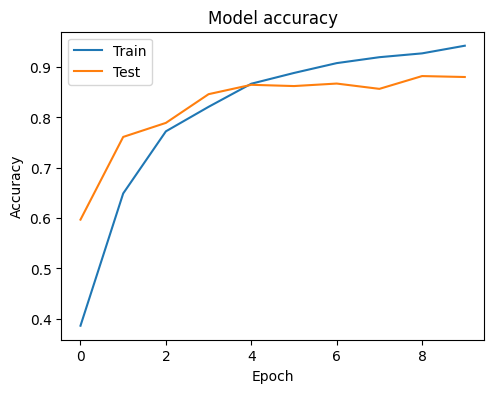

In [111]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

Evaluating the model's loss value throughout the epoch training provides valuable insights into the model's performance and guides us in improving its accuracy and effectiveness.

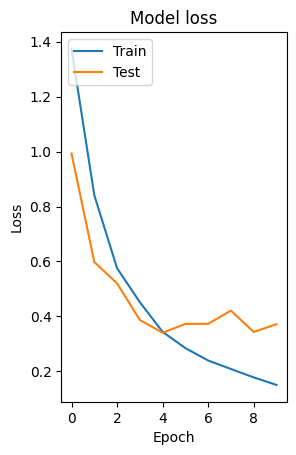

In [112]:
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [113]:
model.save('gesture_recognition_model-annot.h5')